# Inspect dME-model properties

Code for reproducing panels of Figure 3

## Setup environment

In [22]:
import coralme
from coralme.builder.helper_functions import *
import pickle
import pandas
import os
import tqdm
import json
import matplotlib.pyplot as plt
import numpy as np
import sympy
pandas.set_option('display.max_colwidth', None)
plt.rcParams['svg.fonttype'] = 'none'

## Functions to load and inspect models

Load a ME-model

In [2]:
def load_me(filename='me_model.pickle'):
    with open(filename, "rb") as f:
        return pickle.load(f)

Get contigs from GenBank file

In [3]:
def get_genbank_contigs(path):
    import Bio
    gb_it = Bio.SeqIO.parse(path, "gb")
    return [ i for i in gb_it ]

Get property breakdown from a model

In [4]:
def get_info(model, info_flag='all'):
    if info_flag == 'all':
        return {
            'genes':len([i for i in model.genes if 'dummy' not in i.id]),
            'reactions':len(model.reactions),
            'metabolites':len(model.metabolites),
        }
    else:
        return get_breakdown(model,info_flag)

def get_breakdown(model,field):
    count = {}
    for instance in getattr(model,field):
        instance_type = instance.__class__.__name__
        if instance_type not in count.keys():
            count[instance_type] = 0
        count[instance_type] += 1
    return {'genes':count}

Get organism directories in path

In [5]:
def get_org_dirs(directory):
    return [i for i in os.listdir(directory) \
            if os.path.isdir(directory+i) and '.' not in i and '_' not in i]

Load models in a directory

In [6]:
def load_models_from_directory(directory,solve=False):
    d = {}
    dirs = get_org_dirs(directory)
    for i in tqdm.tqdm(dirs):
        modelpath = directory + '{}/MEModel-step2-{}.pkl'.format(i,i)
        d[i] = load_me(modelpath)
        if solve:
            d[i].optimize()
    return d

Main function to get and summarize ME-model properties

In [7]:
def get_specs(models, info_flag = 'all'):
    info = {}
    for k,v in models.items():
        for i,m in v.items():
            m.genes = [g for g in m.metabolites if isinstance(g,coralme.core.component.TranscribedGene)]
            name = i
            if name not in info:
                info[name] = {}
            info[name]['mmodel'] = get_info(m.gem, info_flag=info_flag)['genes']
            if 'clean' in k:
                info[name]['coralme'] = get_info(m, info_flag=info_flag)['genes']
            else:
                info[name]['curated'] = get_info(m, info_flag=info_flag)['genes']
            if info_flag == 'all':
                if name in published_info:
                    info[name]['published'] = published_info[name]['genes']
                info[name]['genome'] = features[name]
    if info_flag == 'all':
        return pandas.DataFrame.from_dict(info).fillna(0).T[['mmodel','coralme','curated','published','genome']].sort_values('published',ascending=True)
    return pandas.DataFrame.from_dict(info).fillna(0).T 

## Load Genomes

In [8]:
features = {}
for org in get_org_dirs('./clean/'):
    p = './clean/{}/inputs/genome.gb'.format(org)
    contigs = get_genbank_contigs(p)
    count = 0
    for c in contigs:
        for f in c.features:
            if not f.type == 'gene': continue
            count += 1
    features[org] = count

## Load dME-models

In [10]:
models = {
    'curated':load_models_from_directory('./published/'),
    'clean':load_models_from_directory('./clean/')
         }

  0%|          | 0/4 [00:00<?, ?it/s]

Read LP format model from file /tmp/tmpi46oxslx.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmpj9tu15eu.lp
Reading time = 0.00 seconds
: 604 rows, 1386 columns, 5940 nonzeros
Read LP format model from file /tmp/tmpxm_sbj9q.lp
Reading time = 0.00 seconds
: 689 rows, 1432 columns, 5894 nonzeros


 25%|██▌       | 1/4 [00:01<00:05,  1.93s/it]

Read LP format model from file /tmp/tmp9mzkp8go.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmpv8x6qjpr.lp
Reading time = 0.00 seconds
: 1660 rows, 4754 columns, 17902 nonzeros
Read LP format model from file /tmp/tmpvzfwmkhx.lp
Reading time = 0.00 seconds
: 1810 rows, 5220 columns, 17878 nonzeros


 50%|█████     | 2/4 [00:07<00:07,  3.92s/it]

Read LP format model from file /tmp/tmpbt1h38to.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmppx66q_8v.lp
Reading time = 0.00 seconds
: 721 rows, 1652 columns, 7064 nonzeros
Read LP format model from file /tmp/tmpq3sr9qme.lp
Reading time = 0.00 seconds
: 747 rows, 1670 columns, 6890 nonzeros


 75%|███████▌  | 3/4 [00:09<00:03,  3.15s/it]

Read LP format model from file /tmp/tmpica_w8zr.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmp3_jo2hlz.lp
Reading time = 0.00 seconds
: 998 rows, 2524 columns, 10562 nonzeros
Read LP format model from file /tmp/tmp99srlzsr.lp
Reading time = 0.00 seconds
: 1088 rows, 2554 columns, 10544 nonzeros


100%|██████████| 4/4 [00:13<00:00,  3.31s/it]


## Load information of published ME-models

In [13]:
with open('published_info.json') as f:
    published_info = json.load(f)
with open('names.json') as f:
    names = json.load(f)

In [12]:
for k,v in names.items():
    print(v)

M. mycoides
H. pylori
L. crescens
T. maritima
N. europaea
L. cremoris
S. elongatus
S. aureus
G. metallireducens
Synechocystis
A. baumannii
C. difficile
Y. pestis
B. subtilis
M. tuberculosis
S. flexneri
C. ljungdahlii
S. enterica
E. coli
V. cholerae
P. putida


## Visualize ME-model specs

Specifications

In [19]:
specs_df = get_specs(models).rename(names)
specs_df

,mmodel,coralme,curated,published,genome
M. tuberculosis,1008.0,1207.0,0.0,0.0,4008.0
H. pylori,339.0,534.0,0.0,0.0,1584.0
C. difficile,900.0,1201.0,0.0,0.0,4016.0
N. europaea,534.0,698.0,0.0,0.0,2660.0
Y. pestis,815.0,1037.0,0.0,0.0,4195.0
P. putida,1462.0,1665.0,0.0,0.0,5786.0
L. crescens,373.0,510.0,0.0,0.0,1435.0
L. cremoris,516.0,706.0,0.0,0.0,2587.0
V. cholerae,960.0,1355.0,0.0,0.0,4007.0
S. aureus,866.0,1054.0,0.0,0.0,2885.0


## Inspecting genes

Distribution of gene increase from M-model to dME-model

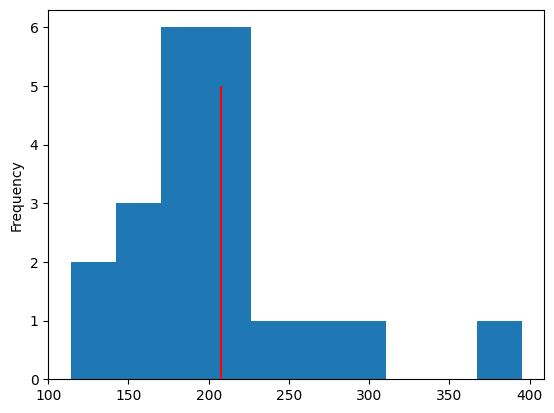

In [20]:
tmp = (specs_df['coralme'] - specs_df['mmodel'])
tmp.plot.hist()
plt.vlines(x=tmp.mean(), ymin = 0, ymax = 5, color='r')
plt.savefig('figures/added_genes_dist.svg',format='SVG')

Gene increase from M-model to dME-model

In [21]:
tmp.sort_values()

M. mycoides           114.0
L. crescens           137.0
T. maritima           149.0
Synechocystis         156.0
N. europaea           164.0
G. metallireducens    178.0
S. aureus             188.0
L. cremoris           190.0
S. elongatus          192.0
H. pylori             195.0
A. baumannii          195.0
M. tuberculosis       199.0
P. putida             203.0
Y. pestis             222.0
S. flexneri           222.0
S. enterica           225.0
C. ljungdahlii        226.0
E. coli               244.0
B. subtilis           262.0
C. difficile          301.0
V. cholerae           395.0
dtype: float64

Gene increase from M-model to dME-model for published ME-models

In [22]:
colors = ['#848484','#80B3DF','#5282AC','#FFAD65']
gene_df = specs_df.drop('genome',axis=1)[['mmodel','coralme','published','curated']]
df = gene_df

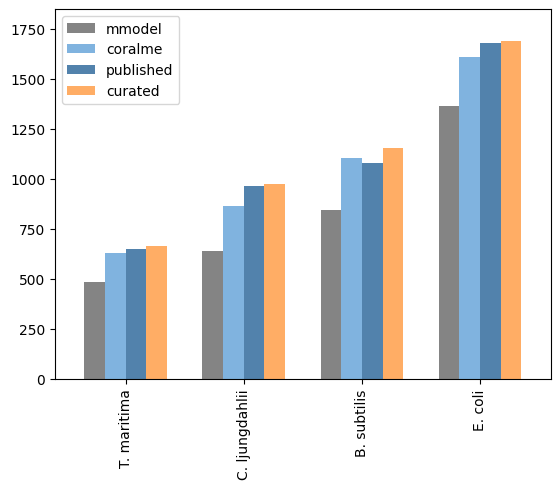

In [23]:
plt.rcParams['svg.fonttype'] = 'none'
df[df['curated']>0].sort_values('curated').plot.bar(
                                   width=0.7,color=colors)
plt.ylim([0,1850])
plt.savefig('./figures/Fig2c.svg',format='SVG')

Gene increase from M-model to dME-model for all other organisms

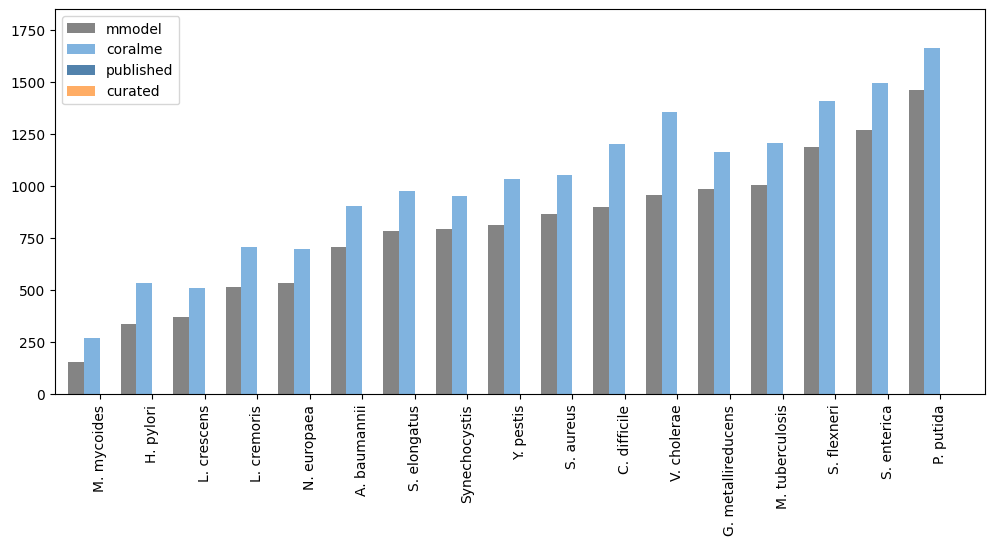

In [24]:
import pandas
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
df[df['curated']==0].sort_values('mmodel').plot.bar(figsize=(12,5),
                                   width=1.2,
                                   color=colors)
plt.ylim([0,1850])

plt.savefig('./figures/Fig2a.svg',format='SVG')

## Genome coverage

Number of genes in all genomes

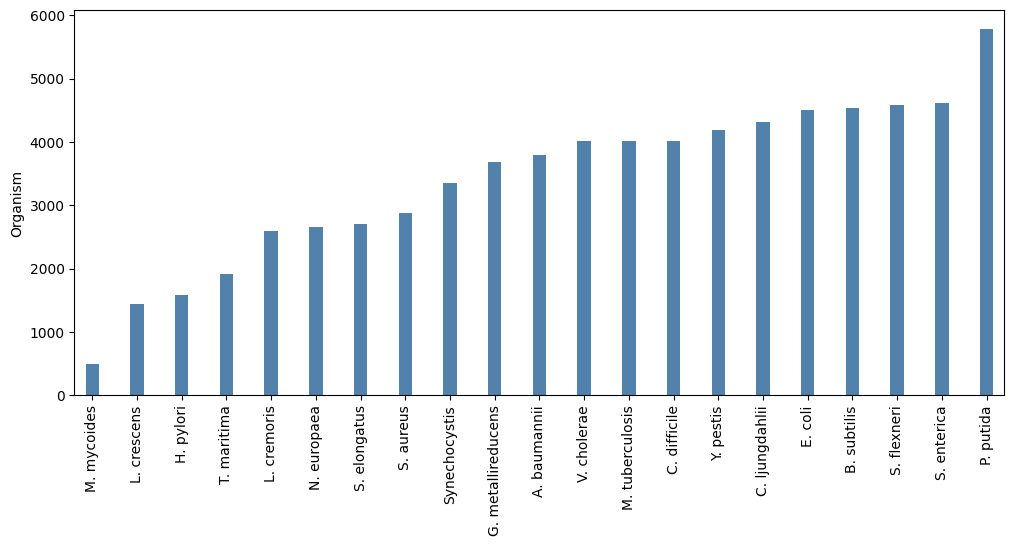

In [25]:
specs_df['genome'].sort_values().plot.bar(color=colors[2], figsize=(12,5),width=0.3)
plt.ylabel('Genome size, # of genes')
plt.ylabel('Organism')
plt.savefig('./figures/genome_sizes.svg',format='SVG')

Coverage of M- and ME-models

In [26]:
colors = ['#848484','#80B3DF','#5282AC','#FFAD65']
cov_df = specs_df.div(specs_df['genome'],axis=0).drop('genome',axis=1)[['mmodel','coralme','published','curated']]
cov_df

,mmodel,coralme,published,curated
M. tuberculosis,0.251497,0.301148,0.000000,0.000000
H. pylori,0.214015,0.337121,0.000000,0.000000
C. difficile,0.224104,0.299054,0.000000,0.000000
N. europaea,0.200752,0.262406,0.000000,0.000000
Y. pestis,0.194279,0.247199,0.000000,0.000000
P. putida,0.252679,0.287764,0.000000,0.000000
L. crescens,0.259930,0.355401,0.000000,0.000000
L. cremoris,0.199459,0.272903,0.000000,0.000000
V. cholerae,0.239581,0.338158,0.000000,0.000000
S. aureus,0.300173,0.365338,0.000000,0.000000


Change in coverage of from M- to dME-models

In [27]:
(cov_df['coralme'] - cov_df['mmodel']).sort_values()

P. putida             0.035085
Synechocystis         0.046470
G. metallireducens    0.048304
S. flexneri           0.048493
S. enterica           0.048828
M. tuberculosis       0.049651
A. baumannii          0.051451
C. ljungdahlii        0.052339
Y. pestis             0.052920
E. coli               0.054258
B. subtilis           0.057760
N. europaea           0.061654
S. aureus             0.065165
S. elongatus          0.070796
L. cremoris           0.073444
C. difficile          0.074950
T. maritima           0.077685
L. crescens           0.095470
V. cholerae           0.098577
H. pylori             0.123106
M. mycoides           0.229839
dtype: float64

Change in coverage of from M- to published ME-models

In [28]:
(cov_df['curated'] - cov_df['published']).sort_values(ascending=False).head(4)

B. subtilis       0.015873
T. maritima       0.007821
E. coli           0.002446
C. ljungdahlii    0.001621
dtype: float64

Coverage increase from M-model to dME-model for published ME-models

In [29]:
df = cov_df

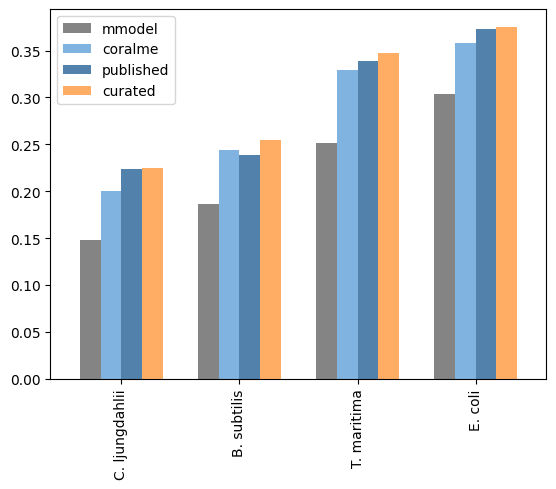

In [30]:
import pandas
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
df[df['curated']>0].sort_values('curated').plot.bar(
                                   width=0.7,color=colors)
plt.savefig('./figures/Fig2c1.svg',format='SVG')

Coverage increase from M-model to dME-model for all other organisms

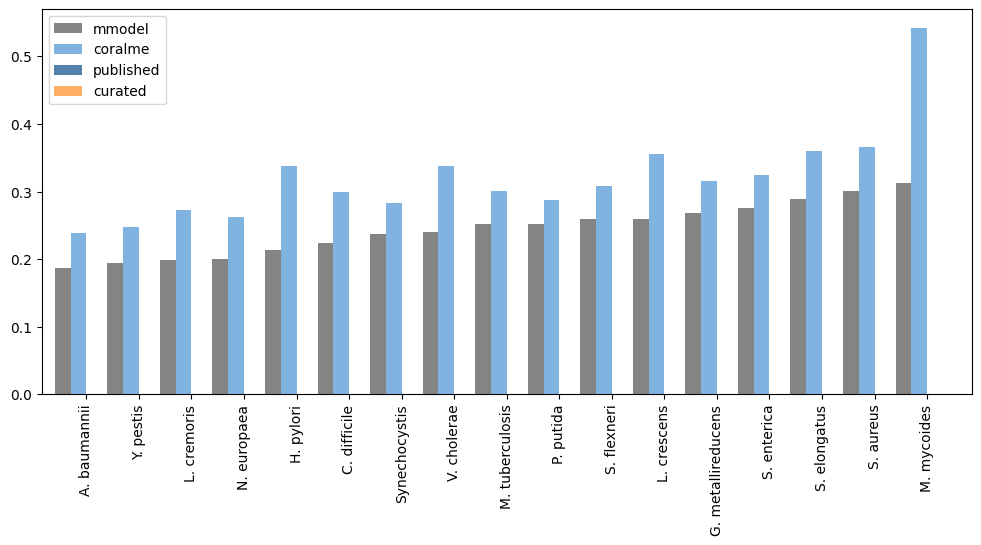

In [31]:
import pandas
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
df[df['curated']==0].sort_values('mmodel').plot.bar(figsize=(12,5),
                                   width=1.2,
                                   color=colors)
plt.savefig('./figures/Fig2a1.svg',format='SVG')

Visualize the same information as heatmaps

In [32]:
import seaborn as sns

In [33]:
cmap = plt.cm.get_cmap('Reds').copy()
# cmap.set_bad('midnightblue')      # color of mask on heatmap
cmap.set_under('white')

/tmp/ipykernel_1422244/2376249781.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds').copy()


Re-order organisms to see the increase more clearly

In [34]:
mlist = [names[i] for i in models['curated']]
df2 = df.loc[mlist][['mmodel','coralme','published','curated']]
df1 = df.drop(mlist)[['mmodel','coralme']].dropna()
order1 = [i for i in cov_df["mmodel"].sort_values().index if i in df1.index]
df1 = df1.loc[order1]
order2 = [i for i in cov_df["mmodel"].sort_values().index if i in df2.index]
df2 = df2.loc[order2]

Plot for published ME-models

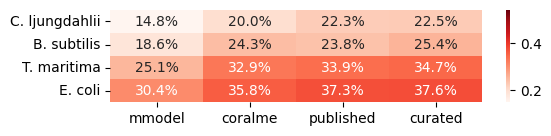

In [27]:
fig,ax = plt.subplots(figsize = (1.5 * df2.shape[1], 0.3 * df2.shape[0]))
sns.heatmap(df2, vmin=df[df>0].min().min(),vmax=df[df>0].max().max(), annot=True,fmt=".1%",cmap=cmap,ax=ax)
plt.savefig('./figures/Fig2d.svg',format='SVG')

Plot for all other ME-models

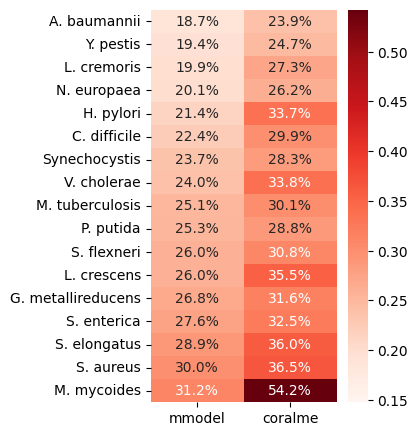

In [28]:
fig,ax = plt.subplots(figsize = (1.5 * df1.shape[1], 0.3 * df1.shape[0]))
sns.heatmap(df1, vmin=df[df>0].min().min(),vmax=df[df>0].max().max(), annot=True,fmt=".1%",cmap=cmap,ax=ax)
plt.savefig('./figures/Fig2b.svg',format='SVG')

## Inspect mapped gene functions in the ME-models

Function to get gene functions

In [10]:
def get_functions(dct):
    from collections import defaultdict
    functions = defaultdict()
    for k,me in dct.items():
        d = defaultdict(int)
        for g in me.all_genes:
            if not g.functions:
                d['none'] += 1
                continue
            for f in g.functions:
                d[f] += 1
        functions[names[k]] = d
    return functions

Get gene functions in the dME-models

In [13]:
fct1 = get_functions(models['clean'])

Get gene functions in the uME-models

In [14]:
fct2 = get_functions(models['curated'])

Summarize the gene functions in dataframes

In [35]:
functions = ['Translation','tRNA-Charging','Post-translation','Transcription']
df1 = pandas.DataFrame.from_dict(fct1).T.fillna(0)[functions + ['none']]
df2 = df1.loc[mlist]
df1["Mapped"] = df1.drop("none",axis=1).sum(axis=1)
df1.drop(mlist,inplace=True)

# df1 = df1.loc[order1]
df1 = df1.sort_values("Mapped")
df2 = df2.loc[order2]

Mapped gene functions to dME-models

In [33]:
df1

,Translation,tRNA-Charging,Post-translation,Transcription,none,Mapped
M. mycoides,112.0,49.0,1.0,15.0,1.0,177.0
L. crescens,127.0,64.0,4.0,21.0,6.0,216.0
Synechocystis,146.0,62.0,3.0,18.0,3.0,229.0
N. europaea,144.0,61.0,7.0,23.0,1.0,235.0
G. metallireducens,154.0,71.0,7.0,26.0,1.0,258.0
S. aureus,177.0,79.0,7.0,21.0,1.0,284.0
L. cremoris,177.0,83.0,3.0,21.0,1.0,284.0
A. baumannii,192.0,92.0,4.0,27.0,4.0,315.0
M. tuberculosis,186.0,104.0,3.0,24.0,2.0,317.0
Y. pestis,196.0,91.0,7.0,27.0,5.0,321.0


Distribution of mapped gene functions by category

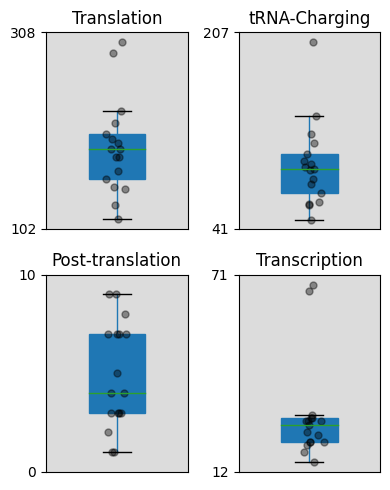

In [34]:
fig,ax = plt.subplots(2,2,figsize=(4,5))
ax=ax.flatten()
for idx,c in enumerate(df1.columns[:-2]):
    bp = df1[[c]].boxplot(vert=True,ax=ax[idx],grid=False,widths = [0.4],showfliers=False,
                          patch_artist = True, return_type='both')
    Y = np.random.normal(1., 0.04,size = df1[[c]].shape[0])
    for i,y in zip(df1[[c]].values,Y):
        ax[idx].plot(y,i,'o',color='k',alpha=0.4,markersize=5)
    
#     for row_key, (ax,row) in bp_dict.iteritems():
#         for i,box in enumerate(row['boxes']):
#             box.set_facecolor('white')
    ax[idx].set_facecolor("gainsboro")
    
    
    start, end = [int(i) for i in ax[idx].get_ylim()]
    ax[idx].set_ylim([max(0,start),end])
    ax[idx].set_title(c)
    ax[idx].yaxis.set_ticks([max(0,start),end+1])
    ax[idx].xaxis.set_ticks([])
plt.tight_layout()
plt.savefig('./figures/Fig2g.svg',format='SVG')

Average mapped gene functions in dME-models

In [35]:
df1.mean()

Translation         187.294118
tRNA-Charging        94.882353
Post-translation      4.882353
Transcription        28.764706
none                  6.705882
Mapped              315.823529
dtype: float64

Mapped gene functions in the dME-models of published ME-models

In [36]:
df2

,Translation,tRNA-Charging,Post-translation,Transcription,none
C. ljungdahlii,198.0,95.0,3.0,20.0,1.0
B. subtilis,222.0,107.0,2.0,23.0,1.0
T. maritima,138.0,67.0,3.0,20.0,1.0
E. coli,211.0,90.0,24.0,29.0,3.0


Final mapped gene functions in uME-models

In [37]:
df3 = pandas.DataFrame.from_dict(fct2).T.fillna(0)[functions]
df3 = df3.rename({k:k + '_curated' for k in df3.index})
df3

,Translation,tRNA-Charging,Post-translation,Transcription
T. maritima_curated,141.0,90.0,3.0,18.0
E. coli_curated,223.0,154.0,29.0,37.0
C. ljungdahlii_curated,212.0,129.0,10.0,21.0
B. subtilis_curated,210.0,136.0,13.0,46.0


Merge the gene functions of dME-models and published ME-models

In [38]:
order3 = [order2[i//2] for i in range(0,len(order2)*2)]
order3 = [i if not idx%2 else i + '_curated' for idx,i in enumerate(order3)]
df4 = pandas.concat([df2,df3]).fillna(0.).loc[order3]
df4.sum(axis=1)

C. ljungdahlii            317.0
C. ljungdahlii_curated    372.0
B. subtilis               355.0
B. subtilis_curated       405.0
T. maritima               229.0
T. maritima_curated       252.0
E. coli                   357.0
E. coli_curated           443.0
dtype: float64

Fraction of gene functions already mapped in the dME-models (compared to final uME-models)

In [39]:
gfp1 = df4[df4.index.str.contains("curated")].drop("none",axis=1).sum(axis=1)
gfp2 = df4[~df4.index.str.contains("curated")].drop("none",axis=1).sum(axis=1)
pandas.DataFrame(gfp2.values/gfp1.values,index=gfp2.index,columns=["fraction"]).sort_values("fraction")

,fraction
E. coli,0.799097
C. ljungdahlii,0.849462
B. subtilis,0.874074
T. maritima,0.904762


Heatmap of mapped gene functions in the dME-models by category

/tmp/ipykernel_2458171/3378120587.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlGnBu').copy()


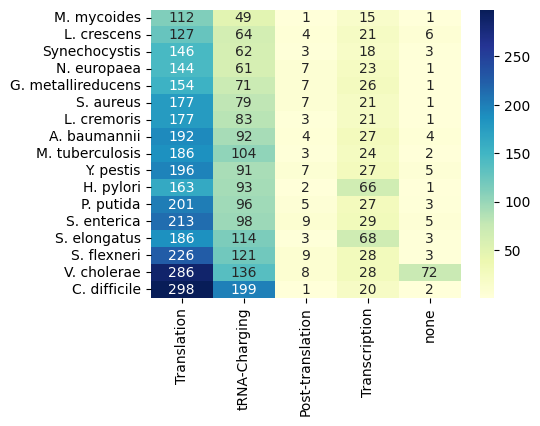

In [40]:
cmap = plt.cm.get_cmap('YlGnBu').copy()
# cmap.set_bad('midnightblue') # color of mask on heatmap
cmap.set_under('white')

tmp = df1[functions + ["none"]]
fig,ax = plt.subplots(figsize = (1.0 * tmp.shape[1], 0.22 * tmp.shape[0]))
hm = sns.heatmap(tmp,vmin=tmp.min().min(),vmax=tmp.max().max(), annot=True,fmt="g",cmap=cmap,ax=ax)
plt.savefig('./figures/Fig2e.svg',format='SVG')

Heatmap of total mapped gene functions in the dME-models

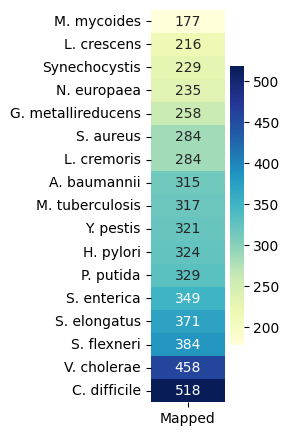

In [41]:
tmp = df1[["Mapped"]]
fig,ax = plt.subplots(figsize = (1.2, 0.3 * tmp.shape[0]))
hm = sns.heatmap(tmp, annot=True,fmt="g",cmap=cmap,ax=ax)
plt.savefig('./figures/Fig2e2.svg',format='SVG')

Heatmap comparing mapped gene functions in the dME-models and uME-models

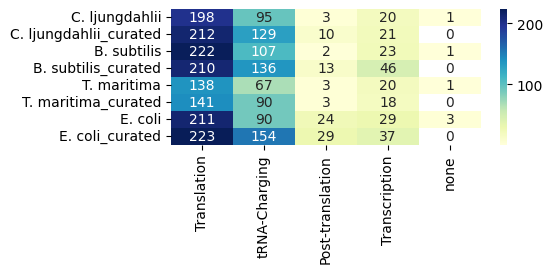

In [42]:
fig,ax = plt.subplots(figsize = (1.0 * df4.shape[1], 0.22 * df4.shape[0]))
hm = sns.heatmap(df4, annot=True,fmt="g",cmap=cmap,vmin=1,vmax=df4.max().max(),ax=ax)
plt.savefig('./figures/Fig2f.svg',format='SVG')

## Computation times

In [43]:
from datetime import datetime
import re

Function to calculate times from log files in each organism's directory.

Run <code> bash get_times.sh </code> in clean/ to get the files necessary for this part.


In [44]:
def get_times(filename):
    times = {}
    for l in open(filename,"r").readlines():
        if l == '\n':continue
        org = re.findall("(?<=\=\=\> \./)[a-z]*",l)
        if org:
            current_org = org[0]
            continue
        tstring = l.split(",")[0]
        dt = datetime.strptime(tstring,"%Y-%m-%d %H:%M:%S")
        times[current_org] = dt
    return times

Get computation times

In [45]:
b1 = get_times("./clean/builder_time1.txt")
b2 = get_times("./clean/builder_time2.txt")
r1 = get_times("./clean/recon_time1.txt")
r2 = get_times("./clean/recon_time2.txt")
t1 = get_times("./clean/ts_time1.txt")
t2 = get_times("./clean/ts_time2.txt")

Get computation times

In [46]:
times = {}
for org in b1.keys():
    # if org in exclude: continue
    times[org] = {
        "sync" : (b2[org] - b1[org]).total_seconds()/60.0,
        "recon" : (r2[org] - r1[org]).total_seconds()/60.0,
        "troub" : (t2[org] - t1[org]).total_seconds()/60.0
    }
df = pandas.DataFrame.from_dict(times).T.rename(names)

Computation times for dME-model reconstruction

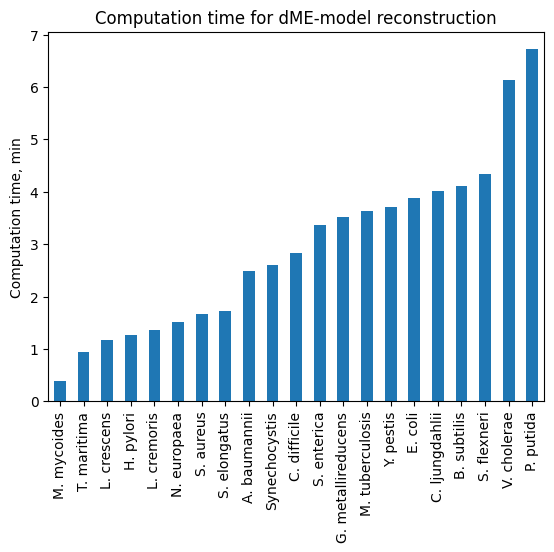

In [47]:
df[['sync','recon']].T.sum().sort_values().plot.bar()
plt.title("Computation time for dME-model reconstruction")
plt.ylabel("Computation time, min")
plt.savefig("./figures/build_timespans.svg",format="SVG")

Average time for dME-model reconstruction in minutes

In [48]:
df[['sync','recon']].sum(1).mean()

2.922222222222222

Computation times for dME-model troubleshooting

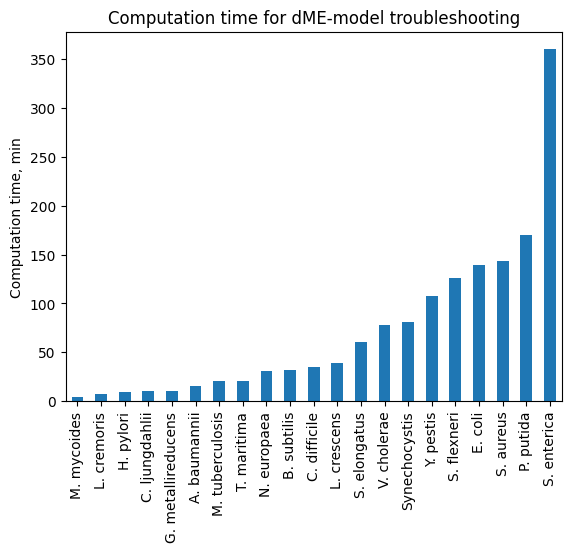

In [49]:
(df[["troub"]].T.sum()).sort_values().plot.bar()
plt.title("Computation time for dME-model troubleshooting")
plt.ylabel("Computation time, min")
plt.savefig("./figures/troubleshoot_timespans.svg",format="SVG")

Average time for dME-model troubleshooting in minutes

In [50]:
df[['troub']].sum(1).mean()

71.65952380952383

## Notes

#### Clostridium had a lot of manual curation on M-reactions

In [51]:
df2=specs_df[specs_df['published']>0]
(df2['published'] - df2['coralme']).div(df2['published'] - df2['mmodel'])

T. maritima       0.118343
C. ljungdahlii    0.310976
B. subtilis      -0.092827
E. coli           0.215434
dtype: float64

In [52]:
df2=specs_df[specs_df['published']>0]
1 - (df2['published'] - df2['coralme']).div(df2['published'] - df2['mmodel'])

T. maritima       0.881657
C. ljungdahlii    0.689024
B. subtilis       1.092827
E. coli           0.784566
dtype: float64

In [53]:
me1 = models['curated']['cljungdahlii']

In [54]:
me2 = models['clean']['cljungdahlii']

In [55]:
len(me1.all_genes)

972

In [56]:
len(me2.all_genes)

863

In [57]:
len(me1.gem.genes)

638

In [58]:
from collections import defaultdict
d = defaultdict(int)
for i in set(i.id for i in me1.all_genes) - set(i.id for i in me2.all_genes):
    g = me1.get(i)
#     print(g.id,g.functions)    
    if any('Metabolic' in j for j in g.functions):
        d['Metabolic'] += 1
    else:
        d['E'] += 1
d

defaultdict(int, {'Metabolic': 66, 'E': 55})